In [1]:
import sinter
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from plotting.threshold_plot import *
import numpy as np
import argparse
import math
import sys
from typing import Optional, List, Any, Tuple, Callable
import sinter


In [13]:



def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        *,
        target_p: float,
        failure_unit_func: Callable[[sinter.TaskStats], float],
        qubit_factor,
        stability=False
) -> Optional[sinter.Fit]:
    assert len({stat.json_metadata['p'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.3:
                p_unit = p_shot
                if stability:
                    sqrt_qs.append(math.sqrt(stat.json_metadata['diameter']**2))
                else:
                    sqrt_qs.append(math.sqrt(stat.json_metadata['d']**2))
                log_ps.append(math.log(p_unit))

    if len(log_ps) < 2:
        # Can't interpolate a slope from 1 data point.
        return None

    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=math.log(target_p),
        max_extra_squared_error=1,
    )
    
    return sinter.Fit(
        low=qubit_factor(fit.low),
        best=qubit_factor(fit.best),
        high=qubit_factor(fit.high),
    )


def teraquop_curve(
        group: List[sinter.TaskStats],
        *,
        target_p: float,
        failure_unit_func: Callable[[sinter.TaskStats], float],
        qubit_factor,
        stability=False
) -> Tuple[List[float], List[float], List[float], List[float]]:
    xs = []
    ys_best = []
    ys_low = []
    ys_high = []
    p_groups = sinter.group_by(group, key=lambda stats: stats.json_metadata['p'])
    for p in sorted(p_groups.keys()):
        p_group = p_groups[p]
        pt = extrapolate_footprint_achieving_error_rate(
            p_group,
            target_p=target_p,
            failure_unit_func=failure_unit_func,
            qubit_factor=qubit_factor,
            stability=stability,
        )
        if pt is not None:
            xs.append(p)
            ys_best.append(pt.best)
            ys_low.append(pt.low)
            ys_high.append(pt.high)
    return xs, ys_low, ys_best, ys_high


def create_teraquop_plot(ax, stats, rounds, noise_model, qubit_factor, color, label,stability=False):
    target_p = 1e-12
    failure_unit_func = None

    markers = "ov*sp^<>8PhH+xXDd|" * 100
    import matplotlib.colors
    colors = list(matplotlib.colors.TABLEAU_COLORS) * 3

    stats= [
        stat
        for stat in stats
        if stat.json_metadata['noise_model'] == noise_model
    ]

    groups = sinter.group_by(stats, key=lambda stats: stats.json_metadata['p'] and stats.json_metadata['noise_model'] == 'SI1000') 

    curves = {
        key: teraquop_curve(
            groups[key],
            target_p=target_p,
            failure_unit_func=failure_unit_func,
            qubit_factor = qubit_factor,
            stability=stability,
        )
        for key in sorted(groups.keys())
    }


    for k, (d, (xs, ys_low, ys_best, ys_high)) in enumerate(curves.items()):
        ax.fill_between(xs, ys_low, ys_high, alpha=0.2, color=color)
    for k, (d, (xs, ys_low, ys_best, ys_high)) in enumerate(curves.items()):
        ax.plot(xs, ys_best, marker=markers[0], color=color, label=label)
    ax.loglog()


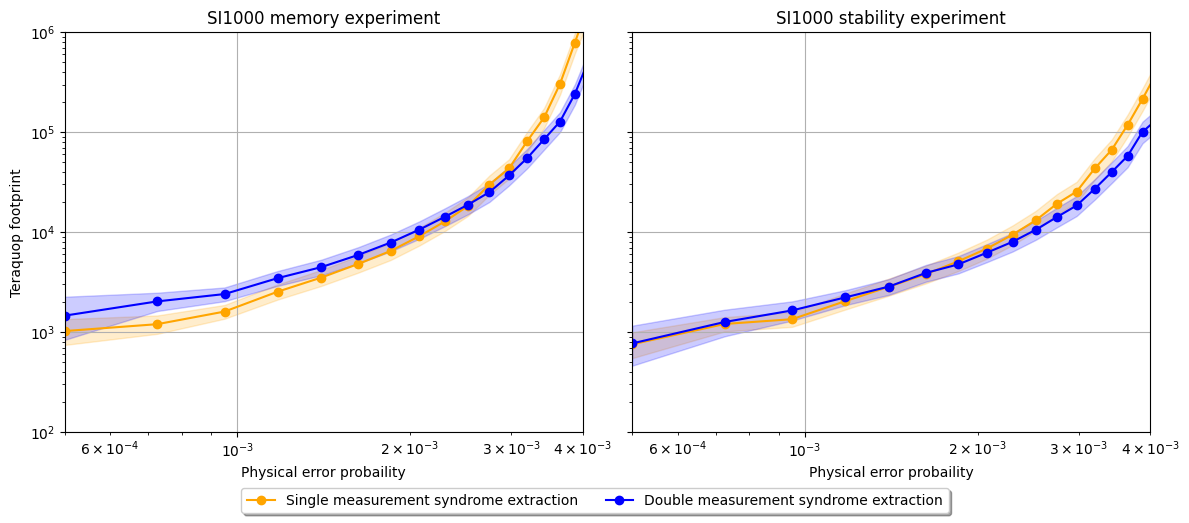

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

samples_normal = sinter.stats_from_csv_files("./13_4_memory_data_new/rotated_surface_code.csv")
samples_double = sinter.stats_from_csv_files("./13_4_memory_data_new/double_measurement_surface_code.csv")


stats: List[sinter.TaskStats] = samples_normal
stats_double: List[sinter.TaskStats] = samples_double

create_teraquop_plot(ax[0], stats, 1, 'SI1000', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[0], stats_double, 1, 'SI1000', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction')

samples_normal = sinter.stats_from_csv_files("./18_5_data_stability/stability_rotated_surface_code.csv")
samples_double = sinter.stats_from_csv_files("./18_5_data/stability_double_measurement_surface_code.csv")

stats: List[sinter.TaskStats] = samples_normal
stats_double: List[sinter.TaskStats] = samples_double
create_teraquop_plot(ax[1], stats, 1, 'SI1000', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction', stability=True)
create_teraquop_plot(ax[1], stats_double, 1, 'SI1000', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction', stability=True)
for axis in ax:
    axis.grid()
    axis.set_xlim(5e-4, 4e-3)
    axis.set_ylim(1e2, 1e6)
ax[0].set_title('SI1000 memory experiment')
ax[0].set_ylabel('Teraquop footprint')
ax[0].set_xlabel('Physical error probaility')

ax[1].set_title('SI1000 stability experiment')
ax[1].set_xlabel('Physical error probaility')

h, l = ax[0].get_legend_handles_labels()
lgd = fig.legend(h, l, loc='lower center', bbox_to_anchor=(0.5, -0.05),
                 ncol=2, fancybox=True, shadow=True, prop={'size': 10})
fig.tight_layout()
plt.savefig('teraquop_results_SI1000', bbox_extra_artists=(lgd,), bbox_inches='tight')


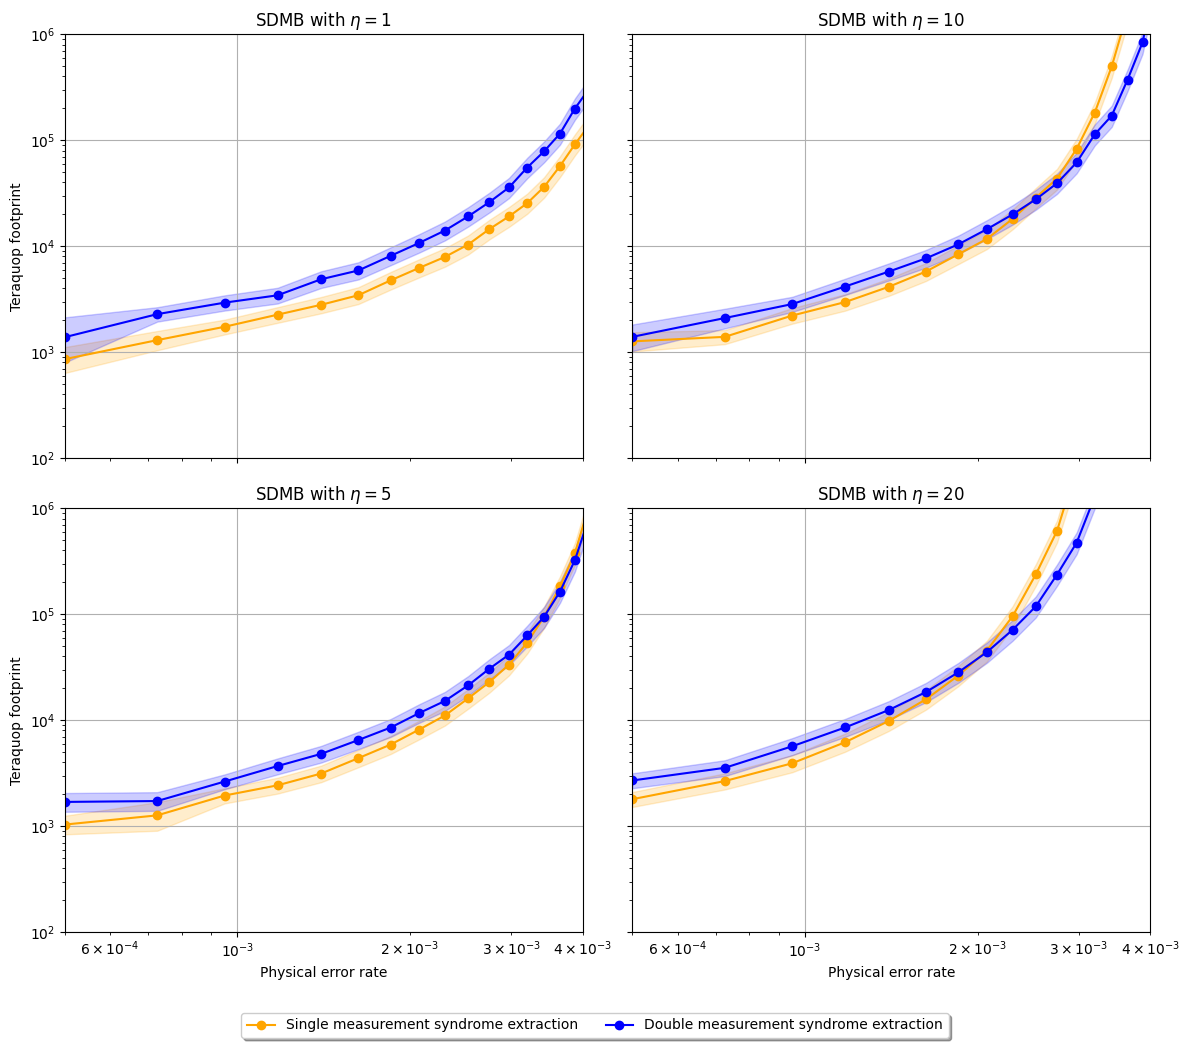

In [15]:
from matplotlib.ticker import LogFormatterSciNotation



fig, ax = plt.subplots(2, 2, figsize=(12,10), sharey=True, sharex=True)

samples_normal = sinter.stats_from_csv_files("./13_4_memory_data_measurement_bias/rotated_surface_code.csv")
samples_double = sinter.stats_from_csv_files("./13_4_memory_data_new/double_measurement_surface_code.csv")

stats: List[sinter.TaskStats] = samples_normal
stats_double: List[sinter.TaskStats] = samples_double

create_teraquop_plot(ax[0][0], stats, 1, 'SD6_1', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[0][0], stats_double, 1, 'SD6_1', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction')

create_teraquop_plot(ax[1][0], stats, 1, 'SD6_5', lambda d: d**2 + (d**2-1), 'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[1][0], stats_double, 1, 'SD6_5', lambda d: d**2 + 2*(d**2-1),'blue','Double measurement syndrome extraction')

create_teraquop_plot(ax[0][1], stats, 1, 'SD6_10', lambda d: d**2 + (d**2-1), 'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[0][1], stats_double, 1, 'SD6_10', lambda d: d**2 + 2*(d**2-1),'blue','Double measurement syndrome extraction')

create_teraquop_plot(ax[1][1], stats, 1, 'SD6_20', lambda d: d**2 + (d**2-1), 'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[1][1], stats_double, 1, 'SD6_20', lambda d: d**2 + 2*(d**2-1),'blue','Double measurement syndrome extraction')


for two_axis in ax:
    for axis in two_axis:
        axis.grid()
        axis.set_xlim(5e-4, 4e-3)
        axis.set_ylim(1e2, 1e6)

ax[0][0].set_title('SDMB with $\eta=1$')
ax[1][0].set_title('SDMB with $\eta=5$')
ax[0][1].set_title('SDMB with $\eta=10$')
ax[1][1].set_title('SDMB with $\eta=20$')

ax[0][0].set_ylabel('Teraquop footprint')
ax[1][0].set_ylabel('Teraquop footprint')
ax[1][0].set_xlabel('Physical error rate')
ax[1][1].set_xlabel('Physical error rate')

h,l = ax[0][0].get_legend_handles_labels()

formatter = LogFormatterSciNotation(labelOnlyBase=False, minor_thresholds=(2, 0.4))
ax[1][0].get_xaxis().set_minor_formatter(formatter)
ax[1][1].get_xaxis().set_minor_formatter(formatter)


lgd = fig.legend(h,l, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fancybox=True, shadow=True, prop={'size': 10})
fig.tight_layout()

plt.savefig('memory_teraquop_results_SDMB.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:

def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        *,
        target_p: float,
        failure_unit_func: Callable[[sinter.TaskStats], float],
        qubit_factor,
) -> Optional[sinter.Fit]:
    assert len({stat.json_metadata['p'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.3:
                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata['diameter']**2))
                log_ps.append(math.log(p_unit))

    if len(log_ps) < 2:
        # Can't interpolate a slope from 1 data point.
        return None

    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=math.log(target_p),
        max_extra_squared_error=1,
    )
    
    return sinter.Fit(
        low=qubit_factor(fit.low),
        best=qubit_factor(fit.best),
        high=qubit_factor(fit.high),
    )


def teraquop_curve(
        group: List[sinter.TaskStats],
        *,
        target_p: float,
        failure_unit_func: Callable[[sinter.TaskStats], float],
        qubit_factor,
) -> Tuple[List[float], List[float], List[float], List[float]]:
    xs = []
    ys_best = []
    ys_low = []
    ys_high = []
    p_groups = sinter.group_by(group, key=lambda stats: stats.json_metadata['p'])
    for p in sorted(p_groups.keys()):
        p_group = p_groups[p]
        pt = extrapolate_footprint_achieving_error_rate(
            p_group,
            target_p=target_p,
            failure_unit_func=failure_unit_func,
            qubit_factor=qubit_factor,
        )
        if pt is not None:
            xs.append(p)
            ys_best.append(pt.best)
            ys_low.append(pt.low)
            ys_high.append(pt.high)
    return xs, ys_low, ys_best, ys_high


def create_teraquop_plot(ax, stats, rounds, noise_model, qubit_factor, color, label):
    target_p = 1e-12
    failure_unit_func = None

    markers = "ov*sp^<>8PhH+xXDd|" * 100
    import matplotlib.colors
    colors = list(matplotlib.colors.TABLEAU_COLORS) * 3

    stats= [
        stat
        for stat in stats
        if stat.json_metadata['noise_model'] == noise_model and float(stat.json_metadata['p']) <= 4e-3
    ]

    groups = sinter.group_by(stats, key=lambda stats: stats.json_metadata['p'] and stats.json_metadata['noise_model'] == noise_model) 
    curves = {
        key: teraquop_curve(
            groups[key],
            target_p=target_p,
            failure_unit_func=failure_unit_func,
            qubit_factor = qubit_factor,
        )
        for key in sorted(groups.keys())
    }
    
    for k, (d, (xs, ys_low, ys_best, ys_high)) in enumerate(curves.items()):
  
        ax.fill_between(xs, ys_low, ys_high, alpha=0.2, color=color)
    for k, (d, (xs, ys_low, ys_best, ys_high)) in enumerate(curves.items()):
        ax.plot(xs, ys_best, marker=markers[0], color=color, label=label)
    ax.loglog()


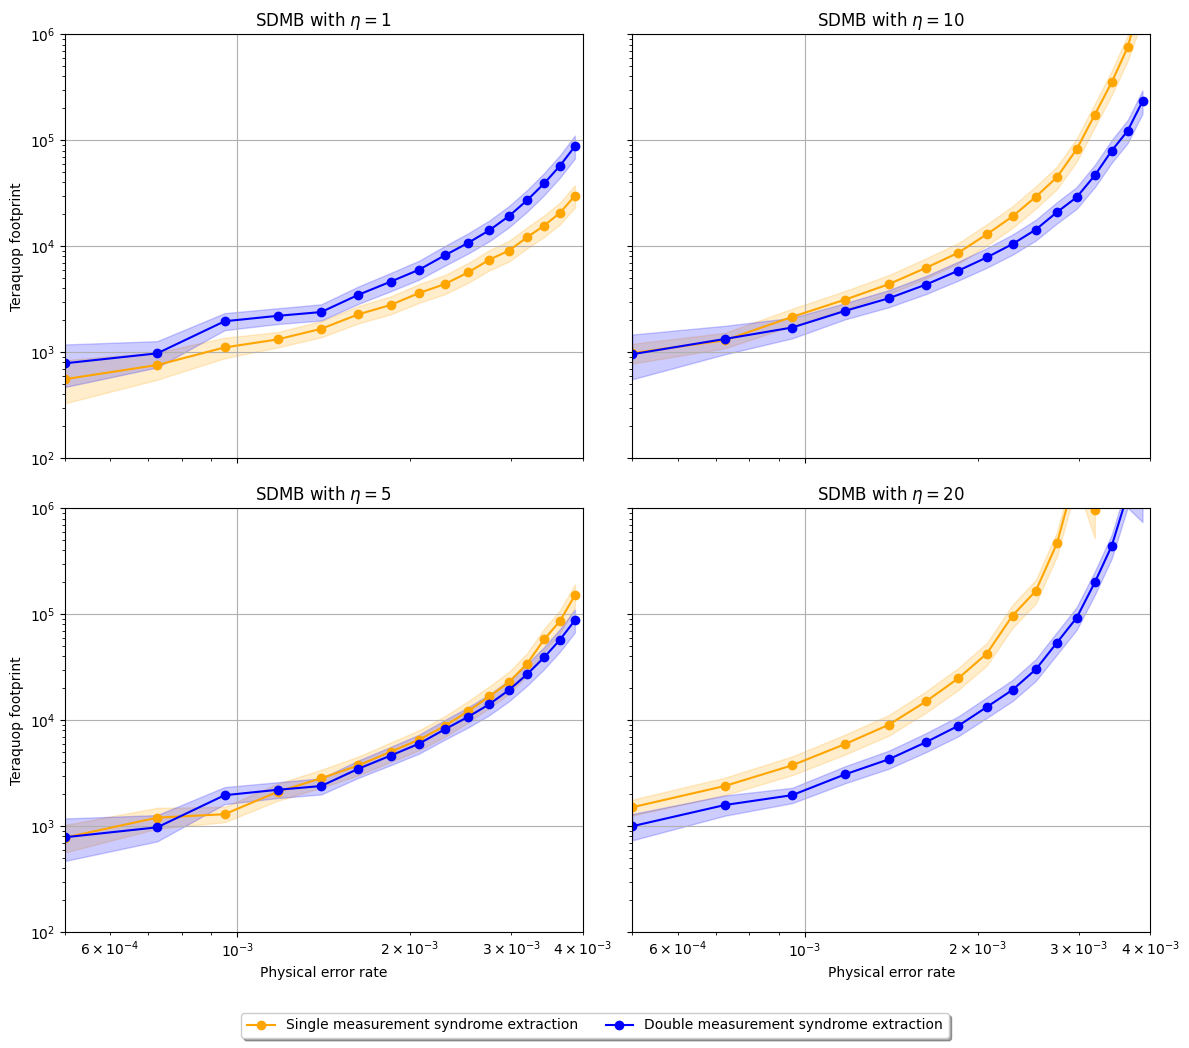

In [12]:
from matplotlib.ticker import LogFormatterSciNotation


fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharey=True, sharex=True)

samples_normal = sinter.stats_from_csv_files("./18_5_data_stability/stability_rotated_surface_code.csv")
samples_double = sinter.stats_from_csv_files("./18_5_data_stability/stability_double_measurement_surface_code.csv")

stats: List[sinter.TaskStats] = samples_normal
stats_double: List[sinter.TaskStats] = samples_double

create_teraquop_plot(ax[0][0], stats, 1, 'SD6_1', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[0][0], stats_double, 1, 'SD6_5', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction')

create_teraquop_plot(ax[1][0], stats, 1, 'SD6_5', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[1][0], stats_double, 1, 'SD6_5', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction')

create_teraquop_plot(ax[0][1], stats, 1, 'SD6_10', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[0][1], stats_double, 1, 'SD6_10', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction')

create_teraquop_plot(ax[1][1], stats, 1, 'SD6_20', lambda d: d**2 + (d**2-1),
                     'orange', 'Single measurement syndrome extraction')
create_teraquop_plot(ax[1][1], stats_double, 1, 'SD6_20', lambda d: d**2 + 2 *
                     (d**2-1), 'blue', 'Double measurement syndrome extraction')

for two_axis in ax:
    for axis in two_axis:
        axis.grid()
        axis.set_xlim(5e-4, 4e-3)
        axis.set_ylim(1e2, 1e6)
ax[0][0].set_title('SDMB with $\eta=1$')
ax[1][0].set_title('SDMB with $\eta=5$')
ax[0][1].set_title('SDMB with $\eta=10$')
ax[1][1].set_title('SDMB with $\eta=20$')

ax[0][0].set_ylabel('Teraquop footprint')
ax[1][0].set_ylabel('Teraquop footprint')
ax[1][0].set_xlabel('Physical error rate')
ax[1][1].set_xlabel('Physical error rate')

h, l = ax[0][0].get_legend_handles_labels()

formatter = LogFormatterSciNotation(labelOnlyBase=False, minor_thresholds=(2, 0.4))
ax[1][0].get_xaxis().set_minor_formatter(formatter)
ax[1][1].get_xaxis().set_minor_formatter(formatter)


lgd = fig.legend(h, l, loc='lower center', bbox_to_anchor=(0.5, -0.05),
                 ncol=2, fancybox=True, shadow=True, prop={'size': 10})
fig.tight_layout()

plt.savefig('stability_teraquop_results_SDMB.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
